 # Mini-Projeto de Visão Computacional
 ## Grupo Turing
 ### Noel Viscome Eliezer

 # Manipulação de Imagens

In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from shutil import copy2
from PIL import Image



In [2]:
# funciona bem em notebooks mas não retorna como arrays
def readImagePIL(filename, show=False):
    try:
        image = Image.open(filename)
    except FileNotFoundError as error:
        print("Erro: arquivo não encontrado.")
        print(error)
        return
    if show:
        image.show()
    return image



In [3]:
# Lê uma imagem. Por padrão assume RGB 8 bits. Filename não tratado.
# bugado pra caralho meu deus do céu
# retorna imagem em RGB pra manter coerente com os outros métodos
def readImageCV(filename, flags=cv2.IMREAD_COLOR, show=False):
    try:
        image = cv2.imread(filename, flags=flags)
    except FileNotFoundError as error:
        print("Erro: arquivo não encontrado.")
        print(error)
        return
    if show:
        cv2.imshow('img', image)
        cv2.waitKey(0)                                  # pra não travar aaaa
        cv2.destroyAllWindows()                         # ainda trava
    # retorna imagem convertida
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



In [4]:
# funciona melhor em notebooks e retorna os valores como matrizes pro numpy
def readImagePlot(filename, show=False):
    try:
        image = plt.imread(filename)
    except FileNotFoundError as error:
        print("Erro: arquivo não encontrado.")
        print(error)
        return
    if show:
        fig, ax = plt.subplots()
        ax.imshow(image)
        ax.axis('off')
        plt.show()
    return image


readImage = readImageCV             # alias para a função


def viewImage(image):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.axis('off')
    plt.show()



 ## Visualizando a imagem
 Usamos algumas imagens para testar

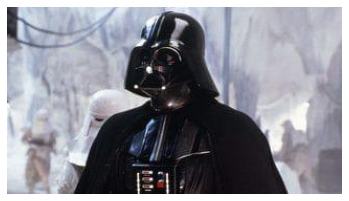

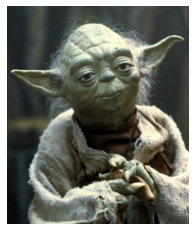

In [5]:
jpg = readImage(r'Darth Vader/darth_vader_fandom1.JPEG')
png = readImage(r'Yoda/yoda_fandom10.PNG')

viewImage(jpg)
viewImage(png)

 ## RGB vs YUV:
 A função `toYUV()` converte RGB para YUV usando a matriz de cores especificada (BT.709 por padrão).
 Para obter uma imagem preto e branco a partir dela, podemos apenas usar o plano Y.

 A função `toBnW()` converte RGB em preto e branco sem mudar o espaço de cores,
 usando como cor a média entre R G e B de cada pixel.

 Todas as funções implementadas agora assumiram que o argumento `image` será um array numpy RGB
 Sinto muito openCV mas nesta casa não trabalhamos com BGR

In [6]:
# isso teoricamente deve funcionar mas não sei qual o melhor jeito de exibir a imagem correta;
# matplotlib só funciona com RGB
def toYUV(image, matrix='709', bnw=False):
    if matrix == '709':
        # R G B
        Y = np.array([0.2126, 0.7152, 0.0722])
        U = np.array([-0.09991, -0.33609, 0.436])
        V = np.array([[0.615, -0.55861, - 0.05639]])
    elif matrix == '601':
        Y = np.array([0.299, 0.587, 0.114])
        U = np.array([-0.14713, -0.28886, 0.436])
        V = np.array([0.615, -0.51499, -0.10001])
    else:
        print('Matriz de cores inválida! Use \'709\' ou \'601\'.')
    # conversão para YUV
    image = image.copy()                               # source é read-only
    for (i, row) in enumerate(image):
        for (j, pixel) in enumerate(row):
            image[i][j] = pixel@np.array([Y, U, V])
    if bnw:
        image = image[:, :, 0]
    return image


def toBnW(image):
    image = image.copy()                               # source é read-only
    for (i, row) in enumerate(image):
        for (j, pixel) in enumerate(row):
            color = np.round(np.mean(pixel))
            image[i][j] = [color, color, color]
    return image


 # Data Augmentation
 Vamos escrever duas funções para manipular na mão as imagens:
 `flip()`: inverte horizontalmente ou verticalmente a imagem
 `brightness()`: ainda em RGB, aumenta o briho das imagens

In [7]:
def flip(image, axis='x'):
    image = image.copy()
    if axis == 'x':
        image = np.flip(image, 1)
    elif axis == 'y':
        image = np.flip(image, 0)
    elif axis == 'xy':
        image = np.flip(image, (0, 1))
    return image


# amount em decimal a multiplicar o brilho atual
def brightness(image, amount):
    image = image.copy()
    image = image/255             # normaliza a imagem para prevenir overflow
    image = image*amount          # garante valores entre 0 e 255
    image = np.clip(image*255, 0, 255)
    image = image.astype(np.uint8)
    return image



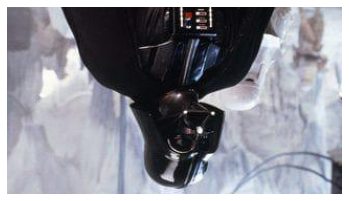

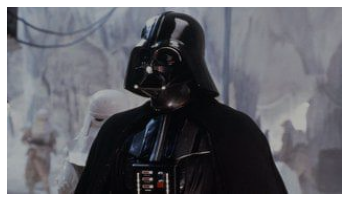

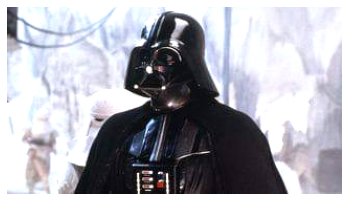

In [8]:
img = jpg
viewImage(flip(img, 'xy'))
viewImage(brightness(img, 0.7))
viewImage(brightness(img, 1.3))

 ## Filtros
 Agora que manipulamos algumas imagens, vamos experimentar alguns filtros.
 Vamos implementar um box blur bem simples (referência: https://en.wikipedia.org/wiki/Kernel_(image_processing))

In [9]:


def boxBlur(image, amount=1):
    kernel = (1/9) * np.ones((3, 3))
    blurred = cv2.filter2D(image, -1, kernel=kernel)
    # itera sobre a imagem já borrada para aumentar o blur
    for i in range(amount - 1):
        blurred = cv2.filter2D(blurred, -1, kernel=kernel)
    return blurred


def sharpen(image, amount=1):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharp = cv2.filter2D(image, -1, kernel=kernel)
    for i in range(amount - 1):
        sharp = cv2.filter2D(image, -1, kernel=sharp)
    return sharp



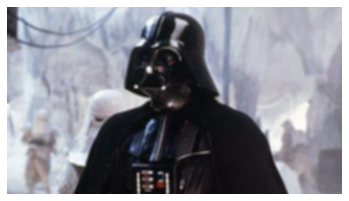

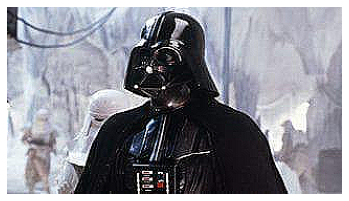

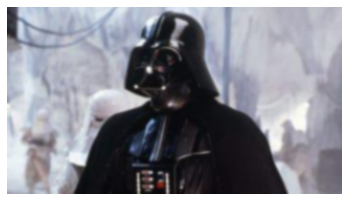

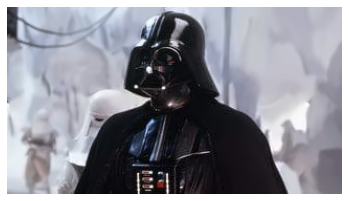

In [10]:
viewImage(boxBlur(jpg))
viewImage(sharpen(jpg))
# usando filtros já embutidos no OpenCV
viewImage(cv2.GaussianBlur(jpg, (0, 0), 1))
viewImage(cv2.fastNlMeansDenoisingColored(jpg))



 # Classificação de Imagens

 ## Organização de bases de treino e teste
 As 3 pastas do dataset estão na mesma pasta do executável
 O formato dos arquivos é a seguir:
 `data`diretório base do dataset
 -- um diretório específico para cada um dos personagems (Yoda, Darth Vader, Stormtrooper)
 ---- train, test e validation em diretórios separados

In [11]:
def train_test_val_split(test_split=0.15, val_split=0.15, root=os.getcwd(), noop=False):
    paths = ["Darth Vader", "Yoda", "Stormtrooper"]
    for path in paths:
        # criamos os diretórios caso não existam
        train_dest = os.path.join(root, "data", "train", path)
        test_dest = os.path.join(root, "data", "test", path)
        validate_dest = os.path.join(root, "data", "validation", path)
        os.makedirs(train_dest, exist_ok=True)
        os.makedirs(test_dest, exist_ok=True)
        os.makedirs(validate_dest, exist_ok=True)

        files = os.listdir(path)
        files = [os.path.join(path, f) for f in files if f.endswith(
            (".jpg", ".png"))]      # garante apenas imagens
        train, validate, test = np.split(random.sample(files, len(files)), [int(
            (1-test_split-val_split)*len(files)), int((1-test_split)*len(files))])
        # noop=True para evitar copiar novamente os arquivos
        if not noop:
            for f in train:
                copy2(f, train_dest)
            for f in test:
                copy2(f, test_dest)
            for f in validate:
                copy2(f, validate_dest)
        print(path + ":", len(train), "imagens de treino,", len(test),
              "imagens de teste, e", len(validate), "imagens de validação.")
    return [os.path.join(root, "data", f) for f in ["train", "test", "validation"]]



In [12]:
# mudar para noop=False para copiar os arquivos; noop=True retorna apenas os diretórios
paths = train_test_val_split(noop=True)
classes = ["Darth Vader", "Stormtrooper", "Yoda"]    # ordem alfabética


Darth Vader: 353 imagens de treino, 76 imagens de teste, e 76 imagens de validação.
Yoda: 209 imagens de treino, 45 imagens de teste, e 45 imagens de validação.
Stormtrooper: 339 imagens de treino, 73 imagens de teste, e 73 imagens de validação.


 ## Criando uma Rede Neural com PyTorch
 ### Transformando imagens em tensores

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomCrop(64, padding=4),
    transforms.Resize((256, 256), Image.NEAREST),           # interpolação afeta de forma relevante?
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1))
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256), Image.NEAREST),           # interpolação afeta de forma relevante?
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train = datasets.ImageFolder(paths[0], transform=train_transform)
test, validation = (datasets.ImageFolder(folder, transform=test_transform) for folder in paths[1:])

train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation, batch_size=64, shuffle=False)



In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)       # rever output channels, to usando 18 pq um outro tutorial usou
        self.conv2 = nn.Conv2d(8, 32, kernel_size=5, stride=2, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)                                # não sei se isso tá certo? https://gist.github.com/gagejustins/76ab1f37b83684032566b276fe3a5289#file-outputsize-py
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = x.view(-1, 32 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


cnn = CNN()
cnn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.0001)

In [15]:
# Treinando a rede
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = cnn(inputs)
        # print(inputs.shape, labels.shape, outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch:", epoch, "Loss:", running_loss)



Epoch: 0 Loss: 15.541191279888153
Epoch: 1 Loss: 13.143637359142303
Epoch: 2 Loss: 11.843085885047913
Epoch: 3 Loss: 9.857086598873138
Epoch: 4 Loss: 8.93758487701416
Epoch: 5 Loss: 8.125506192445755
Epoch: 6 Loss: 7.143981546163559
Epoch: 7 Loss: 6.798161864280701
Epoch: 8 Loss: 6.321073293685913
Epoch: 9 Loss: 5.997291594743729


In [16]:
# Validando a rede
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(validation_loader):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # viewImage(transforms.ToPILImage()(images[0].cpu()).convert('RGB'))
        # print("Predição:", classes[predicted[0]], "Label:",classes[labels[0]])
print('Precisão da rede nas imagens de validação: %.3f%%' % (100.000 * correct / total))



Precisão da rede nas imagens de validação: 56.186%


In [17]:
# Testando a rede
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # viewImage(transforms.ToPILImage()(images[0].cpu()).convert('RGB'))
        # print("Predição:", classes[predicted[0]], "Label:",classes[labels[0]])
print('Precisão da rede nas imagens de teste: %.3f%%' % (100.000 * correct / total))



Precisão da rede nas imagens de teste: 55.155%
